In [ ]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM
using SSMCMain.ModifiedMiCRM.RandomSystems
using SSMCMain.ModifiedMiCRM.GraphAnalysis

Precompiling packages...


In [ ]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto

In [ ]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# True Marsland sampler - no i dependence on ls or Ds

See the RandomSystems/jans_v2.jl file for reference. It is intentionally structured in two levels similar to the original Marsland code, the c and D matrices alone can be generated from a MarslandMatrixGenerator. Then there is the TrueMarslandSampler which contains within it a MarslandMatrixGenerator. The parameters are a slightly modified version of what Marsland uses:

In [13]:
# Any/all of these can be passed to the TrueMarslandGenerator constructure as keyword arguments
"""
T::Int                       # how many resource types there are
M_per_type::Int = 1          # resources per type
Mwaste::Int = 0              # number of waste resources (a special type)
F::Int                       # number of strain specialist families (each have their preferred resource type to eat) 0 <= F <= T
S_per_family::Int = 1        # number of strains per family
Sgen::Int = 0                # number of generalist strains (they have no preffered resource)

# These specify the c and D matrix generation and are exactly the same as in the Marsland paper.
# This sets the cs
muc::Float64 = 1.0
c0::Float64 = 0.0
c1::Float64 = 1.0
q::Float64 = 1.0
# This sets the Ds
s::Float64 = 1.0
fs::Float64 = 0.45
fw::Float64 = 0.45

# Then we need to specify the m, r and l. Marland always just fixed these but I keep it general. For each
# you can pass a single value to keep it fixed or any Distributions.jl distribution that will be used for
# their generation. Note that here the ls are generated as if there was no i index!
m=1.
r=1.
l=0.

# The diffusion constants work exactly the same way, allowing for separate values/distributions for the strains and resources
Ds=1e-10
Dr=1.

# Finally the last thing left are the kappas/resource influxes. As far as I can tell the main method Marsland uses is a
# single influx resource which is always the "first one". Its K is set such that its own preferred resource value is that
# of food_R
food_R=0.
""";

In [15]:
ms = TrueMarslandSampler(;
    T=3,
    F=2,
    S_per_family=4,
    M_per_type=3,
    food_R=100.,
)

ms()

BSMMiCRMParams{Nothing, Nothing, Nothing, Float64}(BMMiCRMParams{Nothing, Float64}([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.006248559327653184 0.8374242597431611 … 3.6495452511475953e-11 2.3349553088533128e-18; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.44926790922780496 0.00043541994919656985 … 6.731889504903286e-9 0.002979644984279677; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 5.166770424722651e-10 4.77429404383852e-39 … 7.515929537538107e-48 5.6015126357

# Modified Marsland sampler - generating all l_i and D_i as in Marsland but independently

Again, see the RandomSystems/jans_v2.jl file for reference search for AdaptedMarsland1 and all the code/logic is self contained and hopefuly relatively clear!

Setup is the exact same with the same parameters too - only difference is that here the ls and Ds are generated independently for every i. This keeps in spirit with or modification but is a bit of a mishmash as we have their structure which however does not account for the is. However this could have different results due to different structures/geometries being available.

In [16]:
ms = AdaptedMarsland1(;
    T=3,
    F=3,
    S_per_family=4,
    M_per_type=3,
    food_R=100.,
    q=1.,
    muc=2.,
    l=0.4,
)

xx = ms();

# New unstructured sampling scheme

Firstly, note that ideas from this could very well be brought to the Marsland sampler too.

Key features:
- all g, w are 1
- maybe let r come from a lognormal but mainly keep it fixed to 1 to set time units
- m and diffusions should come from lognormals
- unsure about c, perhaps also use a lognormal but it would be nice to have it multimodal
    - I think I'm favouring making c also come from a scaled beta!
    - or a lognormal
- l from a beta dist
- for D have a sparsity measure corresponding to the avg number of byproducts but otherwise keep it unstructured
- for influx resources keep similar to what it was, have an influx sparsity and independent Ks

**Okay** - turns out the original generator can already do all this, I just need to pass it the right distributions, here's an example

The only tricky bit is understanding the params, for that see the section below!! for the base10_lognormal for example params of -12 and 0. will correspond to a distribution with average of 10^-12 with no variance. Beta is a bit tricky, idk how to explain it, see viz and wiki.

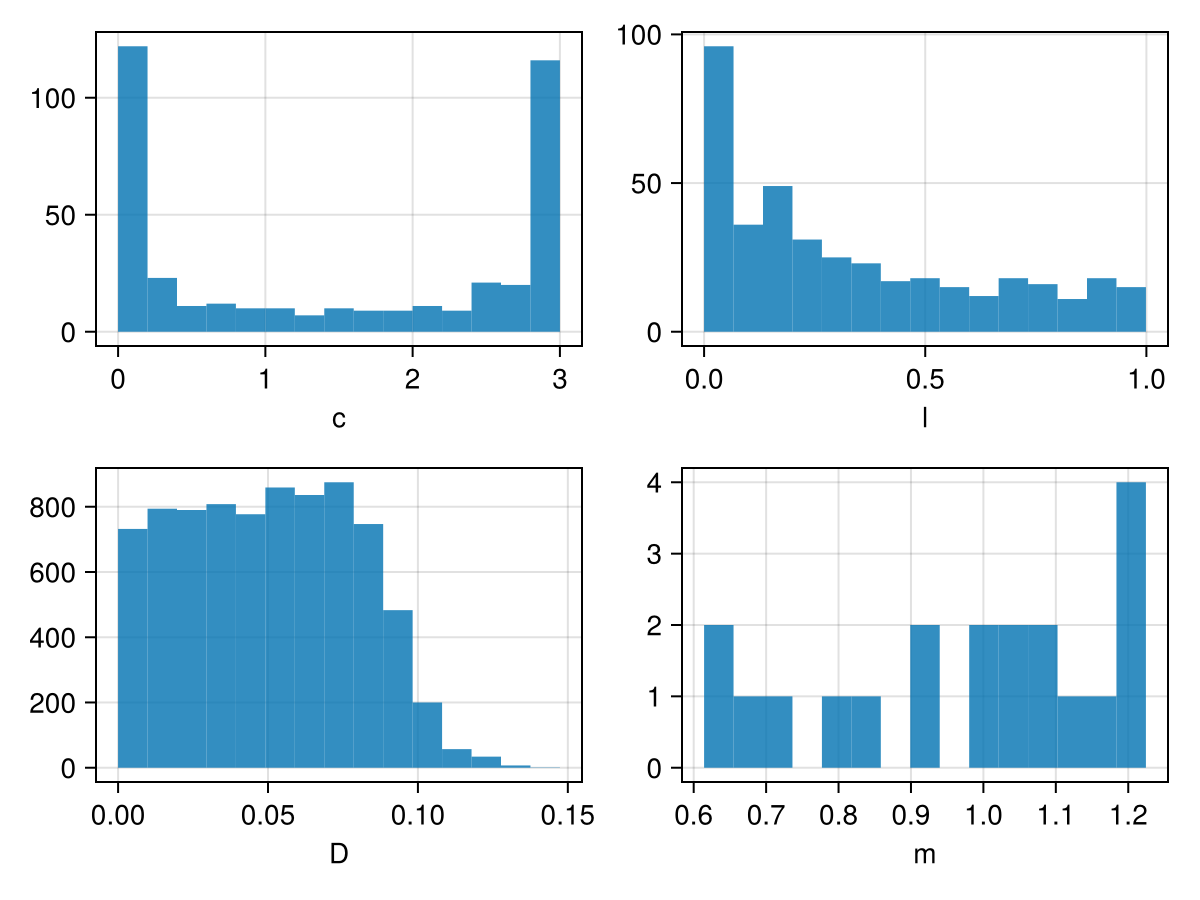

In [17]:
rsg = RSGJans1(20, 20;
    m=base10_lognormal(0., 0.1),
    Ds=base10_lognormal(-12, 0.),
    Dr=base10_lognormal(0., 0.),
    
    l=Beta(0.5, 1),
    c=Beta(0.2, 0.2) * 3, # can scale distributions!!
    sparsity_resources=1.0, # I set these high here just so there's more data for the histograms
    sparsity_byproducts=1.0,

    # fix influx resources as one (as there has been interest in this setup)
    num_influx_resources=Dirac(1),
    K=Dirac(2.),
)

ps = rsg()

f = Figure()
ax1 = Axis(f[1,1]; xlabel="c")
hist!(ax1, ps.c[:])
ax2 = Axis(f[1,2]; xlabel="l")
hist!(ax2, ps.l[:])
ax3 = Axis(f[2,1]; xlabel="D")
hist!(ax3, ps.D[:])
ax4 = Axis(f[2,2]; xlabel="m")
hist!(ax4, ps.m[:])

f

# Visualizing the distributions

In [5]:
# Beta
f = Figure()
sg = SliderGrid(f[1,1],
    (label="alpha", range=range(0.1, 50., 1000)),
    (label="beta", range=range(0.1, 50., 1000))
)
ax = Axis(f[2,1])

N = 1000000

sliderobservables = [s.value for s in sg.sliders]
y1s = lift(sliderobservables...) do slvalues...
    d = Beta(slvalues...)
    rand(d, N)
    # 10 .^ (rand(d, N))
end

hist!(ax, y1s; bins=range(0, 1, 100), label="beta(alpha, beta)")
axislegend(ax)

display(GLMakie.Screen(), f)
# f

GLMakie.Screen(...)

In [20]:
# 10 .^ Normal
f = Figure()
sg = SliderGrid(f[1,1],
    (label="mu", range=range(0., 10., 1000)),
    (label="sigma", range=range(0., 1., 1000))
)
ax = Axis(f[2,1])

N = 1000000

sliderobservables = [s.value for s in sg.sliders]
y1s = lift(sliderobservables...) do slvalues...
    m, s = slvalues
    d = Normal(m, s)
    10 .^ (rand(d, N))
end
y2s = lift(sliderobservables...) do slvalues...
    m, s = slvalues
    d = base10_lognormal(m, s)
    rand(d, N)
end

hist!(ax, y1s; bins=range(-1, 10, 200), label="10 .^ normal(mu, sigma)")
hist!(ax, y2s; bins=range(-1, 10, 200), label="test")
axislegend(ax)

display(GLMakie.Screen(), f)
# f

GLMakie.Screen(...)

In [663]:
# LogNormal vs exp.(Normal)
f = Figure()
sg = SliderGrid(f[1,1],
    (label="mu", range=range(0., 10., 100)),
    (label="sigma", range=range(0., 10., 100))
)
ax = Axis(f[2,1])

N = 1000000

sliderobservables = [s.value for s in sg.sliders]
y1s = lift(sliderobservables...) do slvalues...
    m, s = slvalues
    d = Normal(m, s)
    exp.(rand(d, N))
end

y2s = lift(sliderobservables...) do slvalues...
    m, s = slvalues
    d = LogNormal(m, s)
    rand(d, N)
end

hist!(ax, y1s; bins=range(-1, 10, 100), label="exp(normal(mu, sigma))")
hist!(ax, y2s; bins=range(-1, 10, 100), label="lognormal(mu, sigma)")
axislegend(ax)

display(GLMakie.Screen(), f)
# f

GLMakie.Screen(...)

In [19]:
# Normal*x vs Normal(*x, *x)
f = Figure()
sg = SliderGrid(f[1,1],
    (label="mu", range=range(0., 10., 100)),
    (label="sigma", range=range(0., 10., 100)),
    (label="x", range=range(0., 10., 100)),
)
ax = Axis(f[2,1])

N = 1000000

sliderobservables = [s.value for s in sg.sliders]
y1s = lift(sliderobservables...) do slvalues...
    m, s, x = slvalues
    d = Normal(m, s) * x
    rand(d, N)
end

y2s = lift(sliderobservables...) do slvalues...
    m, s, x = slvalues
    d = Normal(m * x, s * x)
    rand(d, N)
end

hist!(ax, y1s; bins=range(-1, 10, 100), label="t1")
hist!(ax, y2s; bins=range(-1, 10, 100), label="t2")
axislegend(ax)

display(GLMakie.Screen(), f)
# f

GLMakie.Screen(...)

# Running a single system

In [436]:
# ps = rsg();
ps = ms();

In [149]:
ps = params[2];

## No space solver

In [437]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps(),
    callback=nothing,
);
maximum(abs, sss.resid)

  1.507353 seconds (2.87 M allocations: 198.609 MiB, 92.17% compilation time)


3.193221646663046e-14

  0.001072 seconds (506 allocations: 100.359 KiB)


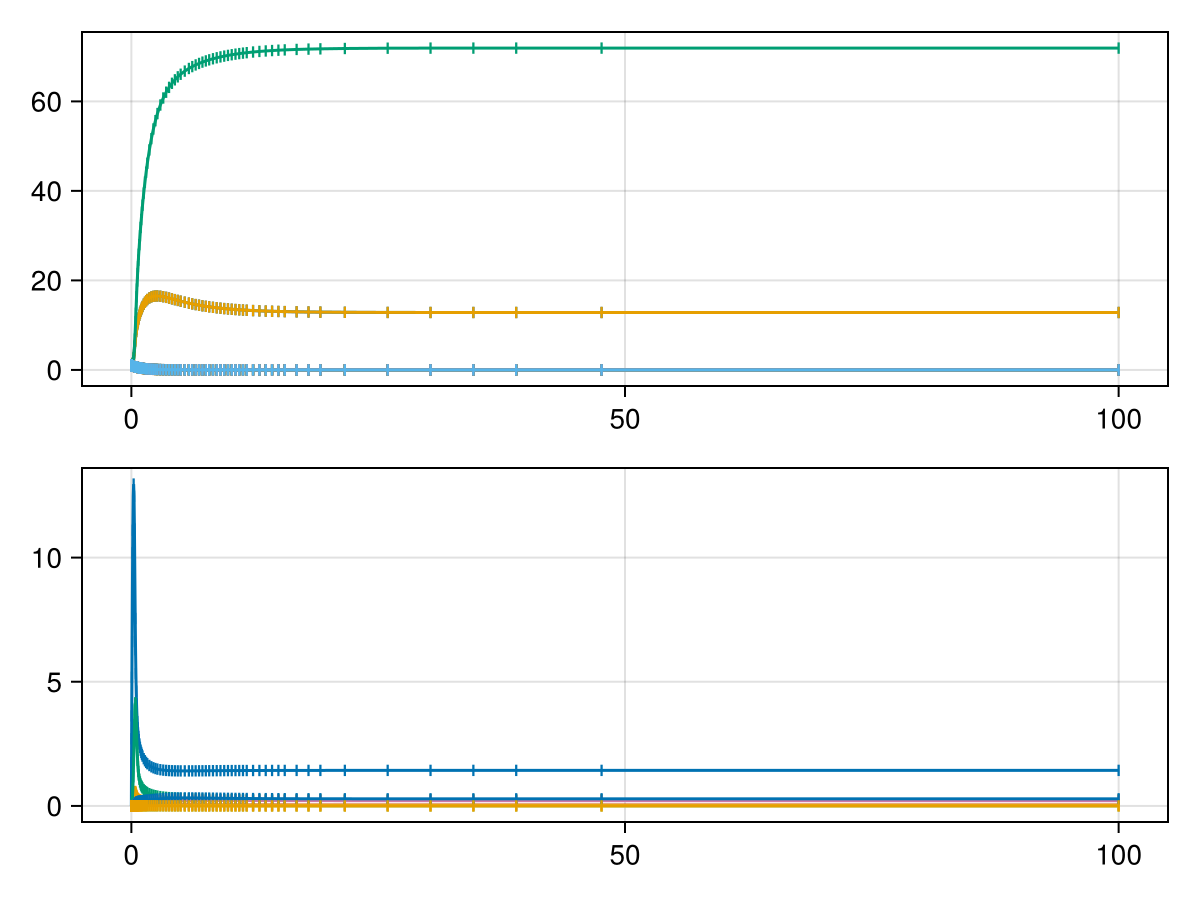

In [438]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 100);
# p = remake_guarantee_positive(p)

@time s = solve(p, QNDF();
    callback=make_timer_callback(1.)
)

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

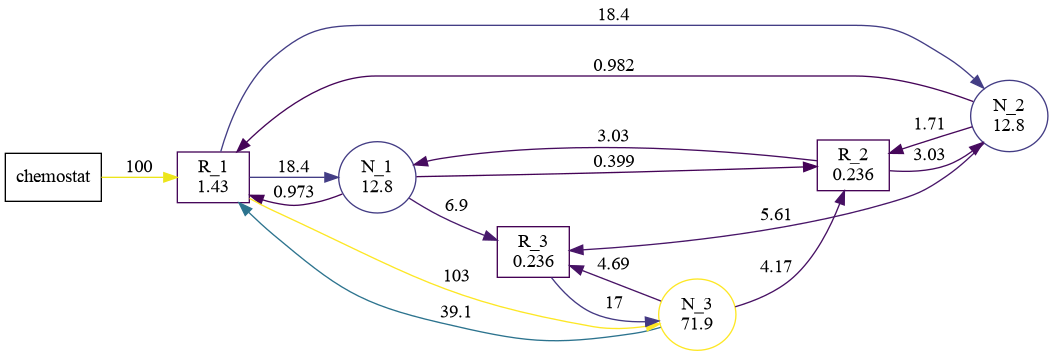

In [439]:
diagram_sfss_v3(ps, s.u[end];
    strain_threshold=1e-5,
    colorscale=identity,
)

## Spatial stuff

In [168]:
# nssol = s.u[end];
nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 1.1988757040423928e-14


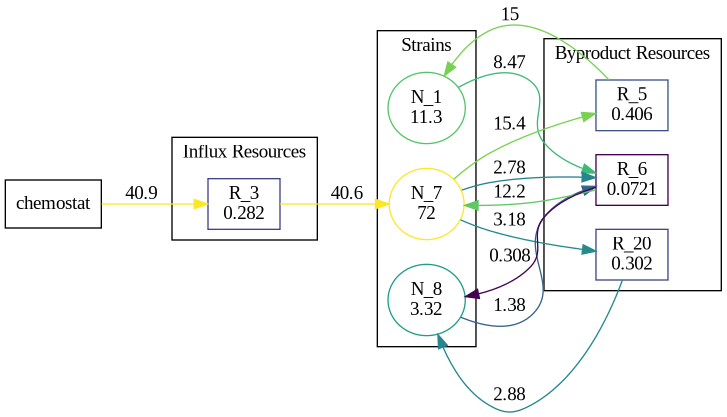

In [176]:
g = diagram_sfss_v3(ps, nssol;
    strain_threshold=1e-10,
    edge_threshold=1e-20,
    cluster=true,
)

### Linear stability

In [196]:
ks = LinRange(0., 1000., 10000)

Ds = get_Ds(ps)
# Ds = vcat(
#     fill(1e-8, get_Ns(ps)[1]),
#     fill(1e-8, get_Ns(ps)[2])
# )
# Ds[20] = 10000

Ns = get_Ns(ps)[1]
Ds[Ns+5] = 1e-3
Ds[Ns+6] = 1e-3
Ds[Ns+20] = 1e-3

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

0.0010819294251180958

[ Info: Unstable, mrl is 0.00108193


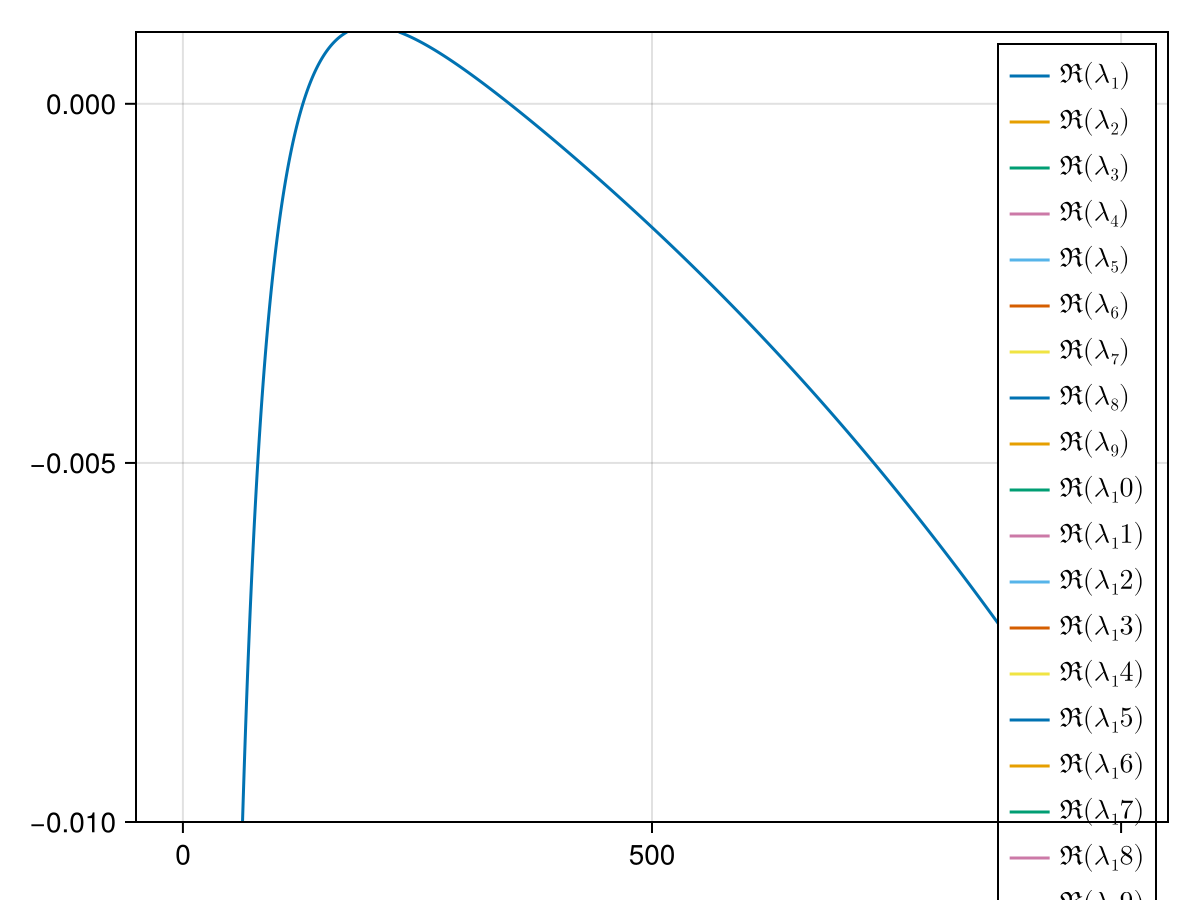

In [197]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.001)
# xlims!(faa.axis, 0., 1000)
faa

### 1D spatial

In [349]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [350]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

  9.385754 seconds (13.18 M allocations: 3.611 GiB, 2.23% gc time, 129.82% compilation time)
Success
nf is 1030
solution has 155 saved states
max resid is 2.55048e-06


┌ Warning: reaching negative values, minimum is -3.34381e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


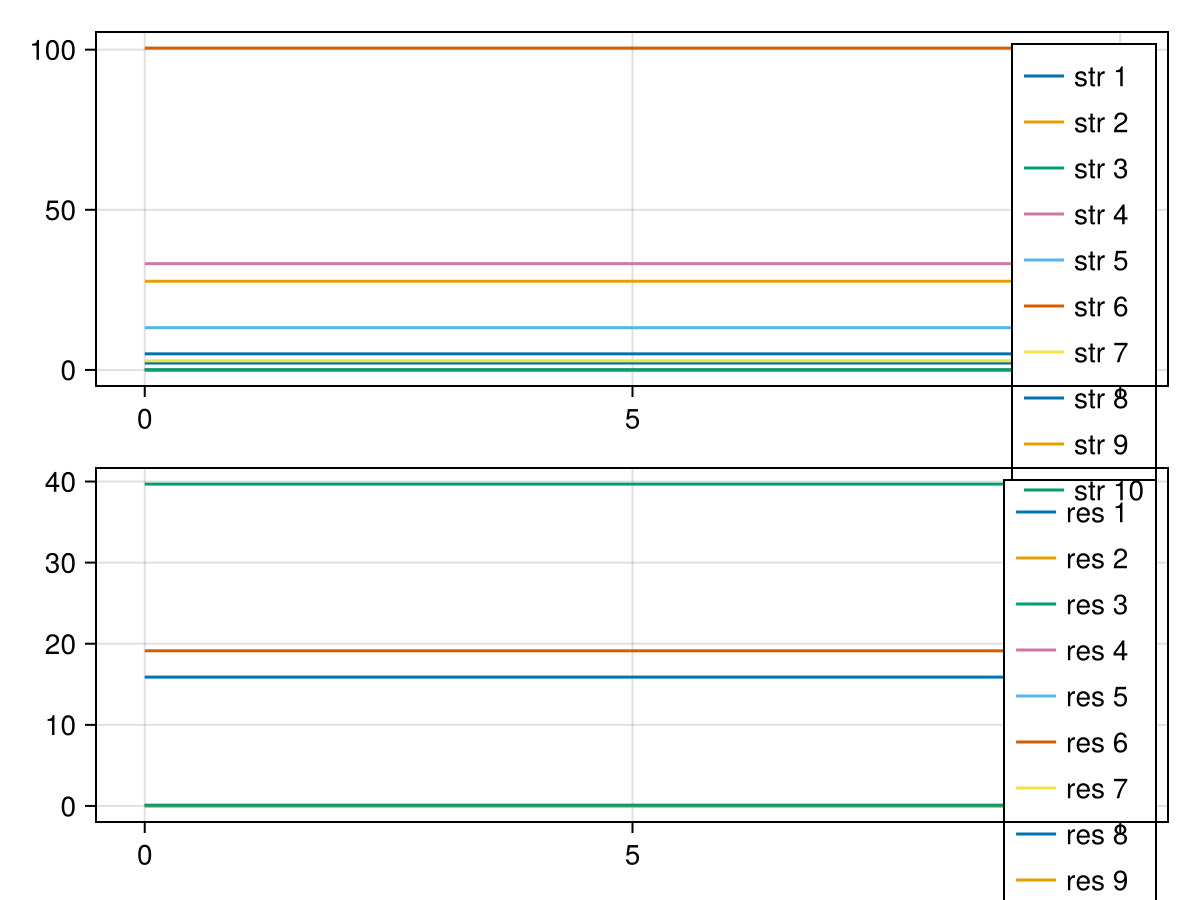

In [352]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

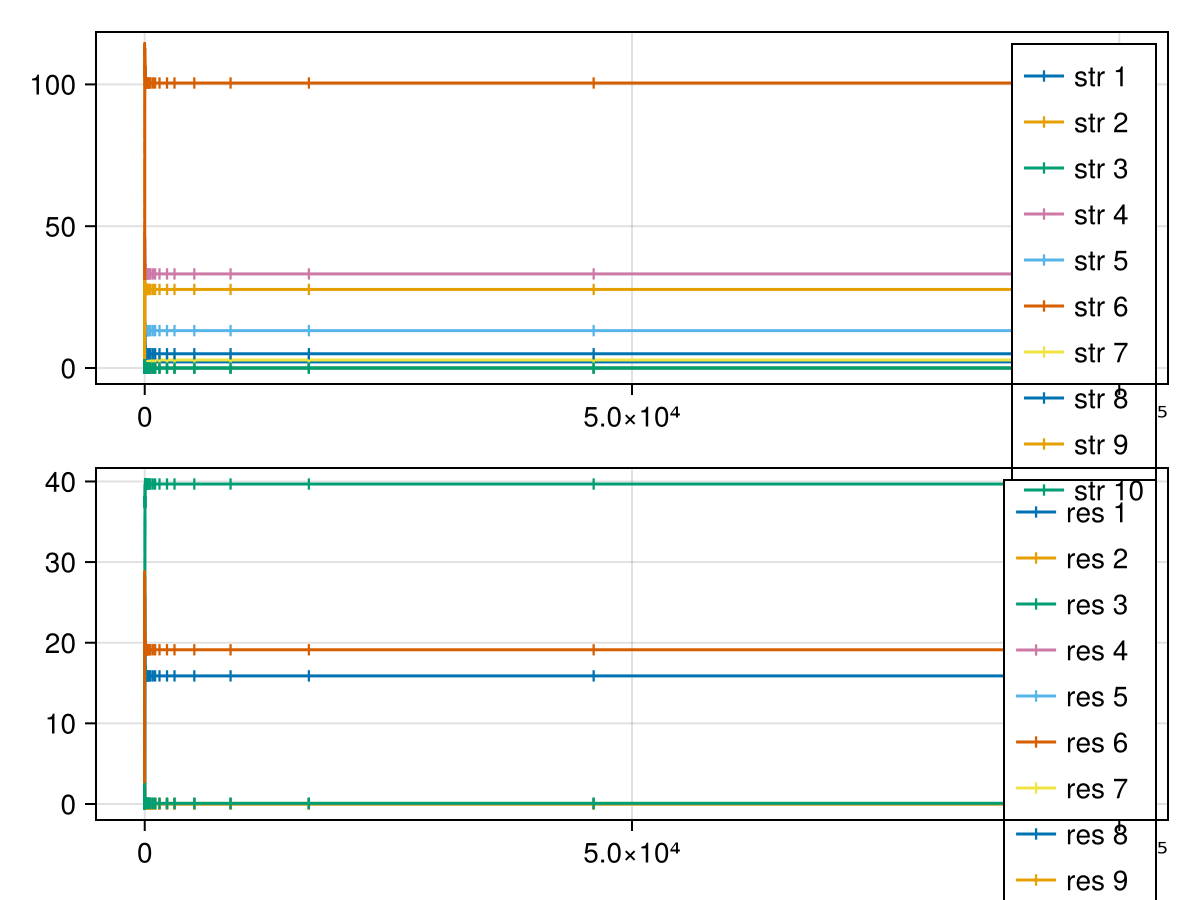

In [353]:
plot_smmicrm_sol_avgs(sps)

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()